In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

import random

%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [3]:
len(words)

32033

In [4]:
# Build the vocabulary of characters and mapping to/from integers
chars = sorted(list(set("".join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


### Boilerplate MLP

In [5]:
# Build Dataset
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
    
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


### Changes and Notes
* `b2 * 0`  and `W2 * 0.1` since we want the logits closer to 0, so we remove the bias and scale down W2
* You can get dead neurons in activation functions. This can be from bad luck, but even if they don't die, you can saturate the activation and significantly slow down learning.
    * If you see this oversaturation, this will be beacuse values that are too extreme are being fed into the activation
    * In our case we can scale down `b1 * 0.01` and `W1 * 0.2`
* In deeper networks (i.e 50), a bad initialization can stop a network from learning entirely
* Initialization used to be a very big problem on large networks, but new tools have loosening some of these constraints
    * Initializations today rely on `kaiming_normal`
    * For our `W1` it's the gain for our non-linearlity `tanh` = (5/3) * the first dimension of `W1`
    * Skip connections, Batch and Layer Norm, better optimizers instead of just SGD like Adam are new tools


In [6]:
# MLP revistited

n_emb = 10 # Dimensionality of the character embedding vectors
n_hidden = 200 # Number of neirons in the hidden layer of the MLP\

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_emb),                generator=g)
W1 = torch.randn((n_emb * block_size, n_hidden),    generator=g) * (5/3)/(n_emb * block_size)**0.5 # 0.2
# b1 = torch.randn((n_hidden),                        generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),            generator=g) * 0.01
b2 = torch.randn((vocab_size),                      generator=g) * 0

# Batch norm trainable parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.zeros((1, n_hidden))
bnmean_running = torch.zeros((1, n_hidden))
bnstd_running = torch.zeros((1, n_hidden))


parameters = [C, W1, W2, b2, bngain, bnbias]
print(sum(p.nelement() for p in parameters)) # total params
for p in parameters:
    p.requires_grad = True

12097


### Batch Norm
* We want to make sure that the values of the hidden layer pre activation are roughly unit Gaussian. Too close to zero and the tanh does nothing. To big and the tanh does too much
* So the idea is to just standardize the hidden state to make it unit Gaussian
* But you want the distribution to be around the Gaussian but not exactly. So we add scale and shift parameters ***LOOK UP***
* In the denominator when the value is being scaled by the std, add a very small $\epsilon$ so that you don't divide by zero
* Whenever you have a batchnorm layer, it ends up subtracting out previous bias in the weight layers. In our case we can remove `b1` since it won't actually do anything and will be wasteful
* BatchNorm "just works" but it can cause a lot of bugs due to the coupling of examples, so try using other more stable normalization techniques.

In [7]:
# Same optimization as MLP 1
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
    
    # Minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    # Forward pass
    emb = C[Xb] # Embed the characters into the vectors
    embcat = emb.view(emb.shape[0], -1) # Concat the vectors
    # Linear Layer
    hpreact = embcat @ W1 # + b1 # Hidden layer pre-activation
    # BatchNorm layer
    #-------------------------------------------------------------------------
    bnmeani = hpreact.mean(0, keepdim=True)
    bnstdi = hpreact.std(0, keepdim=True)
    hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias # Normalize the batch and add scale and shift params
    with torch.no_grad(): # Keep track of runnin batchnorm mean and std
        bnmean_running  = 0.999 * bnmean_running + 0.001 * bnmeani
        bnstd_running  = 0.999 * bnstd_running + 0.001 * bnstdi
    #-------------------------------------------------------------------------
    # Non-linearity
    h = torch.tanh(hpreact) # Hidden layer
    logits = h @ W2 + b2 # output layer
    loss = F.cross_entropy(logits, Yb) # loss function

    # Backward pass
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track stats
    if i % 10000 == 0: # Print every once in a while
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())


      0/ 200000: 3.3239
  10000/ 200000: 2.0322
  20000/ 200000: 2.5675
  30000/ 200000: 2.0125
  40000/ 200000: 2.2446
  50000/ 200000: 1.8897
  60000/ 200000: 2.0785
  70000/ 200000: 2.3681
  80000/ 200000: 2.2918
  90000/ 200000: 2.0238
 100000/ 200000: 2.3673
 110000/ 200000: 2.3132
 120000/ 200000: 1.6414
 130000/ 200000: 1.9311
 140000/ 200000: 2.2231
 150000/ 200000: 2.0027
 160000/ 200000: 2.0997
 170000/ 200000: 2.4949
 180000/ 200000: 2.0199
 190000/ 200000: 2.1707


In [8]:
print(hpreact.shape)
# Mean and std of each of the records of the minibatch
print(hpreact.mean(0, keepdim=True).shape)
print(hpreact.std(0, keepdim=True).shape)


torch.Size([32, 200])
torch.Size([1, 200])
torch.Size([1, 200])


The initial loss is way too high. This indicates the setup is poor. We can calculate an estimated initial loss, by considering the loss function and the problem.

In [9]:
# At initialiation, we would expect that the probability of every character to be the same, so 1/27
# So we would take that prob and negative log it to get our loss
-torch.tensor(1/27.0).log()

tensor(3.2958)

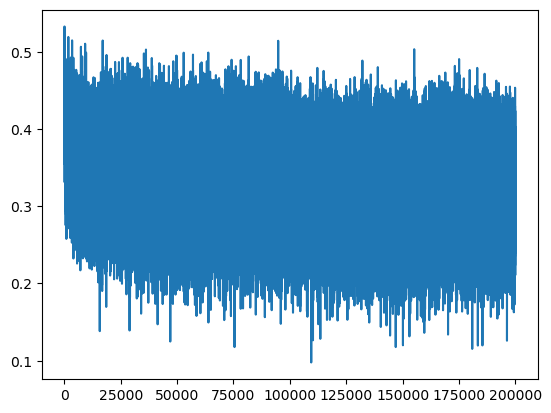

In [10]:
plt.plot(lossi);

`@torch.no_grad()` Basically tells the function beneath it that any tensors will not need to do gradient tracking. It improves efficiency

In [12]:
# Calibrate the batch norm at the end of the training
# Basically clamping the estimated batched values so that you can do inference 1 item at a time
# But no one wants this extra step. So these values are kept as a running mean and std during training

# with torch.no_grad():
#     emb = C[Xtr]
#     embcat = emb.view(emb.shape[0], -1)
#     hpreact = embcat @ W1 + b1
#     # measure the mean/std over the entire training set
#     bnmean = hpreact.mean(0, keepdim=True)
#     bnstd = hpreact.std(0, keepdim=True)


If we were to check we would see that bnmean is roughly equal to bnmean_ running and the same for the stds

In [14]:
@torch.no_grad() # This decorator disables gradient tracking
def split_loss(split):
    x,y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]

    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 #+ b1
    hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0674145221710205
val 2.1056838035583496


### Log Loss

* Original
    * train 2.125
    * val   2.168
* Fix softmax confidently wrong
    * train 2.069
    * val   2.131
* Fix tanh layer too saturated init
    * train 2.036
    * val   2.103
* Add BatchNorm Layer *Doesn't make a difference in such a small network*
    * train 2.067
    * val   2.104

In [ ]:
# Sample from the model

g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1,-1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break

    print(''.join(itos[i] for i in out))

carmah.
amille.
khirmrex.
taty.
skanden.
jazonel.
den.
arci.
aqui.
ner.
kentzieiivia.
legy.
dham.
jorn.
quintis.
lilea.
jadii.
waythoniearynix.
kaeliigh.
boe.


### Putting everything together
Let's pytorchify the code

In [58]:
class Linear:
  
    def __init__(self, fan_in, fan_out, bias=True):
        self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
        self.bias = torch.zeros(fan_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weight
        if self.bias is not None:
            self.out += self.bias
        return self.out

    def parameters(self):
        return [self.weight] + ([] if self.bias is None else [self.bias])


class BatchNorm1d:
  
    def __init__(self, dim, eps=1e-5, momentum=0.1):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters (trained with backprop)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
        # buffers (trained with a running 'momentum update')
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
  
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self.beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
                self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
        return self.out
  
    def parameters(self):
        return [self.gamma, self.beta]

class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return [] 

### Adding BatchNorm Layer
* Usually placed between linear layers and activation
* Completely fine to also place it after the last linear layer before the loss function
    * But if you did that, you have to change the gamma of the batch norm to be less confident, not the weight of the previous linear layer
* You can be more cavelier with the gain value now

In [73]:
n_emb = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_emb), generator=g)
layers = [
    Linear(n_emb * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
    Linear(          n_hidden, vocab_size), BatchNorm1d(vocab_size), 
]

with torch.no_grad():
    # last layer: make less confident
    # layers[-1].weight += 0.1
    layers[-1].gamma += 0.1
    # all other layers: apply gain
    for layer in layers[:-1]:
        if isinstance(layer, Linear):
            layer.weight *= 1 # 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
print(sum(p.nelement() for  p in parameters))
for p in parameters:
    p.requires_grad = True

47551


In [74]:
# same optimization as before
max_steps = 200000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
    # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (batch_size, ), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix] # Batch X,Y

    # forward pass
    emb = C[Xb]
    x = emb.view(emb.shape[0], -1) # Concat the vectors
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, Yb) # loss function

    # Backward Pass
    for layer in layers:
        layer.out.retain_grad() # AFTER_DEBUG: would take out retain grpah
    for p in parameters:
        p.grad = None
    loss.backward()

    # Update
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    # Track Stats
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    with torch.no_grad():
        ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

    if i >= 1000: break # Obviusly take out after Debugging

      0/ 200000: 3.6833


### Network Initialization Analysis

layer 2 (Tanh): mean -0.00, std: 0.63, saturated: 2.69%
layer 5 (Tanh): mean 0.00, std: 0.65, saturated: 2.25%
layer 8 (Tanh): mean 0.00, std: 0.65, saturated: 2.09%
layer 11 (Tanh): mean -0.00, std: 0.65, saturated: 1.34%
layer 14 (Tanh): mean 0.00, std: 0.66, saturated: 1.28%


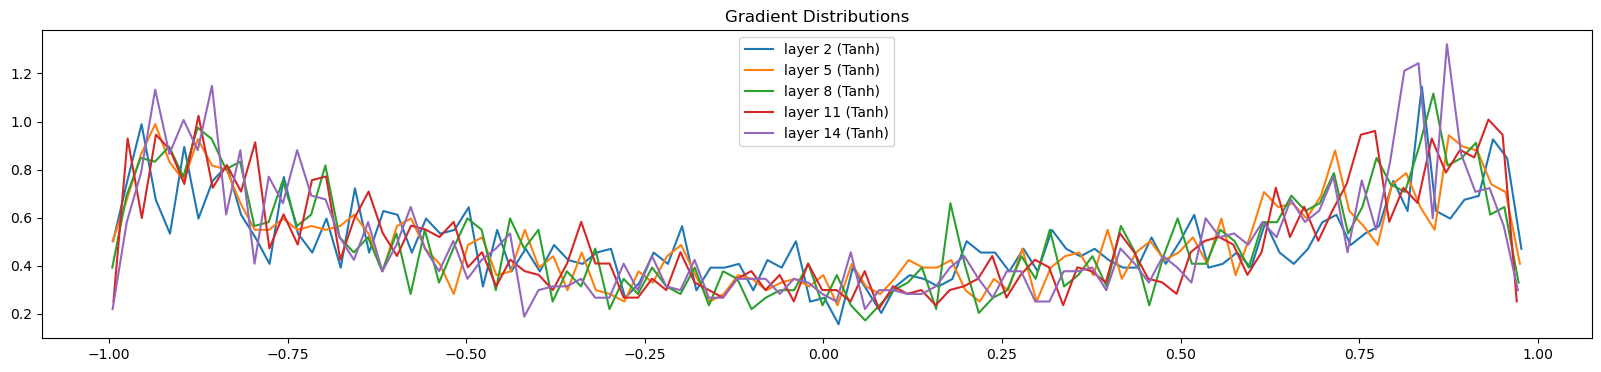

In [75]:
# visualize histogram Tanh analysis
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # Exclude output error
    if isinstance(layer, Tanh):
        t = layer.out
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():.2f}, std: {t.std():.2f}, saturated: {(t.abs() > 0.97).float().mean()*100:.2f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Gradient Distributions');

layer 2 (Tanh): mean -0.000000, std: 0.002537, saturated: 0.000000%
layer 5 (Tanh): mean -0.000000, std: 0.002185, saturated: 0.000000%
layer 8 (Tanh): mean -0.000000, std: 0.002110, saturated: 0.000000%
layer 11 (Tanh): mean -0.000000, std: 0.002089, saturated: 0.000000%
layer 14 (Tanh): mean -0.000000, std: 0.002175, saturated: 0.000000%


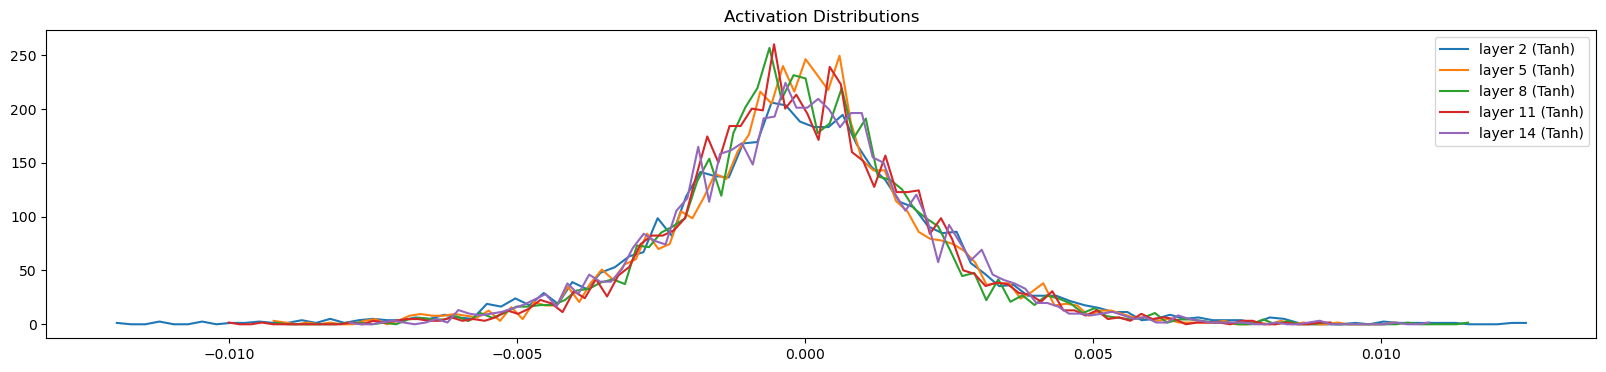

In [76]:
# visualize histogram Tanh gradient analysis
plt.figure(figsize=(20,4))
legends = []
for i, layer in enumerate(layers[:-1]): # Exclude output error
    if isinstance(layer, Tanh):
        t = layer.out.grad
        print(f'layer {i} ({layer.__class__.__name__}): mean {t.mean():f}, std: {t.std():f}, saturated: {(t.abs() > 0.97).float().mean()*100:f}%')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} ({layer.__class__.__name__})')
plt.legend(legends)
plt.title('Activation Distributions');

weight (27, 10) | mean -0.000000 | std: 8.539003e-03 | grad:data ratio 8.528964e-03
weight (30, 100) | mean 0.000251 | std: 9.679109e-03 | grad:data ratio 5.078492e-02
weight (100, 100) | mean -0.000019 | std: 6.923820e-03 | grad:data ratio 6.695055e-02
weight (100, 100) | mean -0.000020 | std: 6.184102e-03 | grad:data ratio 5.986351e-02
weight (100, 100) | mean 0.000002 | std: 5.748106e-03 | grad:data ratio 5.607643e-02
weight (100, 100) | mean 0.000019 | std: 5.666690e-03 | grad:data ratio 5.533063e-02
weight (100, 27) | mean -0.000189 | std: 1.288724e-02 | grad:data ratio 1.196331e-01


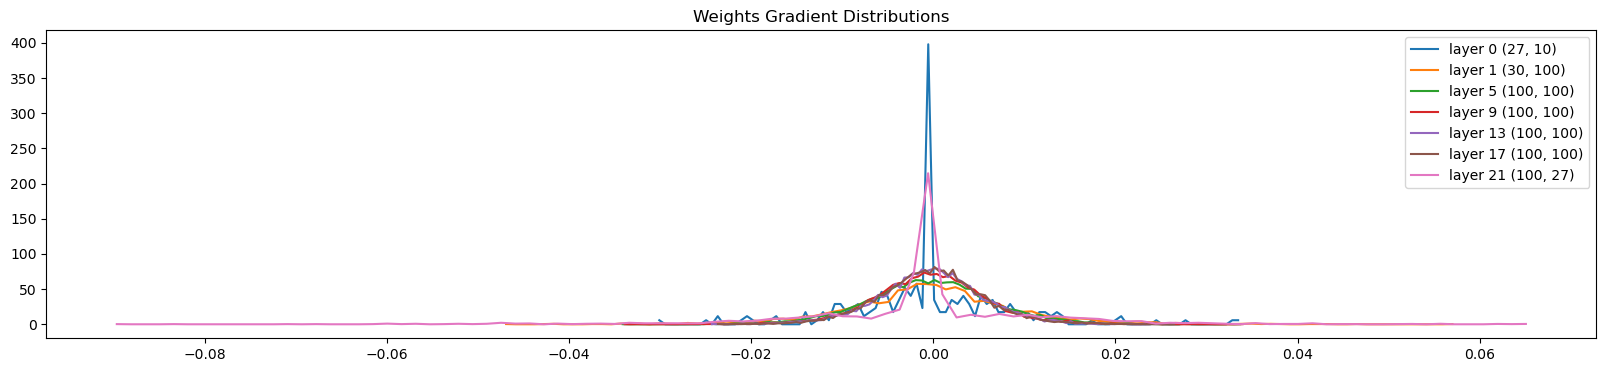

In [77]:
# visualize histogram Gradint to weight ratios analysis
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters): # Exclude output error
    t = p.grad
    if p.ndim == 2:
        print(f'weight {tuple(p.shape)} | mean {t.mean():f} | std: {t.std():e} | grad:data ratio {t.std()/p.std():e}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
        legends.append(f'layer {i} {tuple(p.shape)}')
plt.legend(legends)
plt.title('Weights Gradient Distributions');

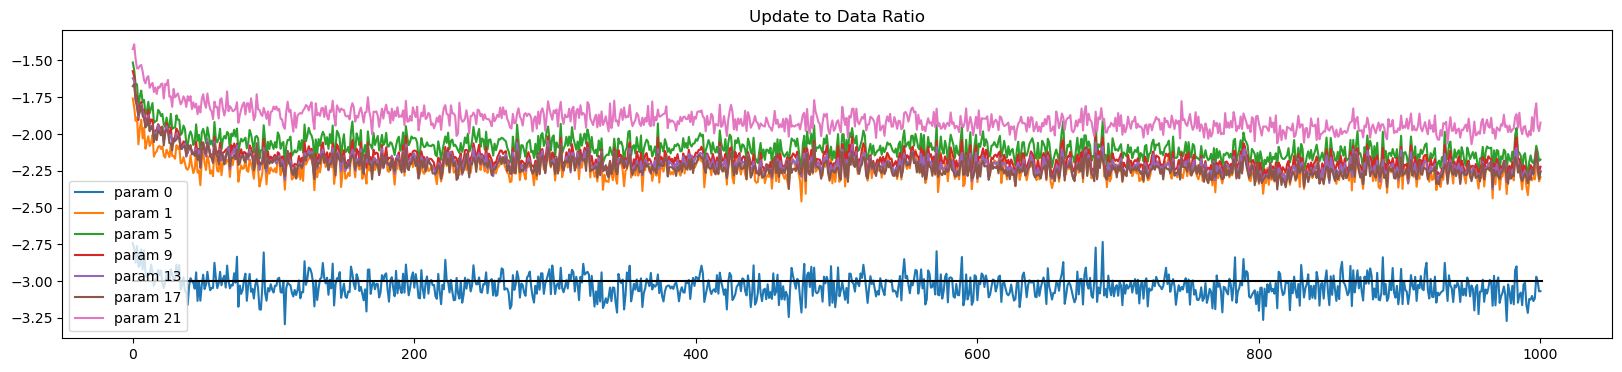

In [78]:
# visualize parameter update
plt.figure(figsize=(20,4))
legends = []
for i, p in enumerate(parameters): # Exclude output error
    if p.ndim == 2:
        plt.plot([ud[j][i] for j in range(len(ud))])
        legends.append('param %d' % i)
plt.plot([0, len(ud)], [-3,-3], 'k')
plt.legend(legends)
plt.title('Update to Data Ratio');